In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D, LSTM
from tensorflow.keras import utils
import tensorflow as tf
from tensorflow import keras
import h5py   

In [2]:
classifies = ['Audi','hyundai','lexus','mazda','Mercedes','opel','toyota','volkswagen','Bu']
classifies2 = classifies[:8]    #Loại lớp bù

path = "Class/"

In [3]:
data = []
labels = []
imagePaths = []

#Kích cỡ quy định cho các tấm ảnh trong lớp phải quy về kích cỡ chung với nhau
WIDTH = 128
HEIGHT = 128

N_CHANNELS = 3      #Kênh màu, Phải có 3 kênh RGB

#1.Lưu đường dẫn của hình ảnh và chỉ số thư mục chứa nó
for index, name in enumerate(classifies):
    for file in os.listdir(path+ name):
        imagePaths.append( [path+name +'/'+file, index])

#2.>>> Quan trọng : Xáo trộn sắp xếp ngẫu nhiên lại các phân tử mảng imagePaths[]
import random
random.shuffle(imagePaths)
print(imagePaths[:10])

#3. Đọc từng ảnh, thay đổi kích cỡ ảnh và lưu trữ chỉ số ảnh
for imagePath in imagePaths:
    image = cv2.imread(imagePath[0])            #Đọc ảnh từ đường dẫn
    image = cv2.resize(image, (WIDTH,HEIGHT))  #thay đổi kích cỡ hỉnh ảnh
    data.append(image)

    #Thêm lớp nhãn từ đường dẫn hình ảnh và cập nhật danh sách
    label = int(imagePath[1])
    labels.append(label)

print('Số lượng ảnh: {0}'.format(len(data)))

[['Class/lexus/images150_rotate_90_111.jpg', 2], ['Class/lexus/images191.jpg', 2], ['Class/toyota/images96.jpg', 6], ['Class/hyundai/110000004922831.jpg', 1], ['Class/opel/images86_rotate_90_261.jpg', 5], ['Class/mazda/images251.jpg', 3], ['Class/hyundai/images30_rotate_90_139.jpg', 1], ['Class/volkswagen/images349_rotate_90_204.jpg', 7], ['Class/mazda/mazda_logo-3d-model-25451-131314_rotate_90_263.jpg', 3], ['Class/lexus/r8_rotate_90_288.jpg', 2]]
Số lượng ảnh: 7969


In [4]:

data = np.array(data, dtype='float32')/255
labels = np.array(labels)
print(labels)

[2 2 6 ... 5 2 7]


Chia sẽ và huấn luyện dư liệu

In [5]:
#Chia dữ liệu ra làm 2 phần trong đó: train(70%) và test(30%)
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.3, random_state=50)

In [7]:
#Trước quy trình nhãn lớp

trainY = utils.to_categorical(trainY, num_classes= len(classifies))
#trainX = np.squeeze(trainX, axis=-1)

#Nếu kích cỡ ảnh resize càng lớn thì số hình ảnh huấn luyện càng ít. Ví dụ: 2100/128(kích cỡ ảnh resize) = 16; 2100/32 = 65
#Số lượng resize càng nhỏ thì chạy càng lâu => Chưa chắc hiệu quả
#Học ít thì mấy lớp gần giống nhau thì khó phân biệt. Còn học nhiều thì bị rối
#Nếu 500 tấm hình trên mỗi đối tường thì Epoch có gía trị tầm 30-35
#Nếu 500 tấm hình trên mỗi đối tường thì Epoch có gía trị tầm 120-280

print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

#Các biến quan trọng

EPOCHS = 30
INIT_LR = 1e-3
BS = 32
#----------------
class_names = classifies

(5578, 128, 128, 3)
(2391, 128, 128, 3)
(5578, 9, 9)
(2391,)


1.Mô hình kiến trúc CNN && Chạy Thủ và đánh giá

In [8]:

model = Sequential()  #khởi tạo một mô hình tuần tự .Kiểu mô hình tuần tự cho phép thêm các lớp mạng theo thứ tự tuần tự.

model.add(Convolution2D(32, (2,2), activation='relu', input_shape=(HEIGHT, WIDTH, N_CHANNELS)))

# Lớp này thực hiện phép lấy mẫu tối đa (max pooling) trên đầu ra của lớp trước đó. Pooling giúp giảm kích thước của dữ liệu và cải thiện khả năng chống nhiễu của mô hình
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Convolution2D(32, (2,2), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#Lớp Dropout() Này ngẫu nhiên bỏ 1 tỷ lệ các nỏ-ron ra trong quá trình huấn luyện, giúp ngăn ngừ mô hình học thuộc lòng (overfitting)
model.add(Dropout(0.25))

#Flatten(): Lớp này chuyển đổi dữ liệu đầu ra từ dạng 3 chiều (chiều cao, rộng, số kênh) thành dạng 1 chiều (vector), chuẩn bị cho các lớp Dense tiếp theo.
model.add(Flatten())

#Lớp Dense(): có 128 nơ-ron và sử dụng hàm kích hoạt ReLU.
model.add(Dense(128, activation='relu'))

#Lớp Dropout(0.5) hủy bỏ 50% các nơ-ron đầu ra trong quá trình huấn luyện.
model.add(Dropout(0.5))

#Lớp Dense():có 8 nơ-ron và sử dụng hàm kích hoạt softmax để cho ra xác suất thuộc một trong 8 lớp (output classes).
model.add(Dense(len(classifies), activation='softmax'))

#biên dịch mô hình. Quá trình biên dịch xác định hàm mất mát (loss function), bộ tối ưu hóa (optimizer) và các số liệu đánh giá (metrics) được sử dụng trong quá trình huấn luyện mô hình.
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 127, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 31, 31, 32)        0         
                                                                 
 flatten (Flatten)           (None, 30752)           

In [ ]:
#Huấn luyện mô hình CNN
model.fit(trainX, trainY, batch_size=BS, epochs=EPOCHS, verbose=1)

2.Mô hình kiến trúc InceptionV3 && Chạy Thủ và đánh giá

In [12]:
from tensorflow.keras.applications import InceptionV3, MobileNet, VGG16, DenseNet121, EfficientNetB7
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras import layers
from keras import models

print('[INFO] compiling model...')
inceptionv3 = InceptionV3(input_shape=(128,128,3), include_top=False, weights = 'imagenet')
for layer in inceptionv3.layers:
  layer.trainable = False

model2 = Sequential()

model2.add(inceptionv3)
model2.add(GlobalAveragePooling2D())
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))

model2.add(layers.Dense(len(classifies), activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=INIT_LR, decay=INIT_LR/EPOCHS)
model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model2.summary())

[INFO] compiling model...


ValueError: decay is deprecated in the new Keras optimizer, please check the docstring for valid arguments, or use the legacy optimizer, e.g., tf.keras.optimizers.legacy.Adam.

In [15]:
#Huấn luyện mô hình InceptionV3
model2.fit(trainX, trainY, batch_size=BS, epochs=EPOCHS, verbose=1)

Epoch 1/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 161s 777ms/step - accuracy: 0.3355 - loss: 2.9546
Epoch 2/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 135s 739ms/step - accuracy: 0.5889 - loss: 1.5385
Epoch 3/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 131s 750ms/step - accuracy: 0.6542 - loss: 1.2731
Epoch 4/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 129s 736ms/step - accuracy: 0.6960 - loss: 1.1117
Epoch 5/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 129s 734ms/step - accuracy: 0.6942 - loss: 1.0792
Epoch 6/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 131s 750ms/step - accuracy: 0.7014 - loss: 1.0723
Epoch 7/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 129s 738ms/step - accuracy: 0.7201 - loss: 0.9657
Epoch 8/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 129s 739ms/step - accuracy: 0.7182 - loss: 0.9315
Epoch 9/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 131s 749ms/step - accuracy: 0.7374 - loss: 0.9238
Epoch 10/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 133s 759ms/step - accuracy: 0.7346 - loss: 0.9087
Epoch 11/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 130s 740ms/step - accuracy: 0.7342 - loss: 0.9135
Epoch 12

3.Mô hình kiến trúc MobileNet && Chạy Thủ và đánh giá

In [24]:
from tensorflow.keras.applications import InceptionV3, MobileNet, VGG16, DenseNet121, EfficientNetB7
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras import layers
from keras import models

print('[INFO] compiling model...')
mobilenet = MobileNet(input_shape=(HEIGHT, WIDTH, N_CHANNELS), include_top=False, weights = 'imagenet')

#Khi ta train tất cả cá lớp của mobinet sẽ bị train lại. Vì thế ta nên đóng băng nó tại đây
for layer in mobilenet.layers:
  layer.trainable = False

model3 = Sequential()

model3.add(mobilenet)
model3.add(GlobalAveragePooling2D())
model3.add(layers.Dropout(0.5))
model3.add(layers.Flatten())
model3.add(layers.Dense(len(class_names), activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=INIT_LR, decay=INIT_LR/EPOCHS)
model3.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model3.summary())

[INFO] compiling model...


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenet_1.00_128 (Functional) │ ?                      │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_7      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,228,864 (12.32 MB)

None


In [25]:
#Huấn luyện mô hình MobileNet
model3.fit(trainX, trainY, batch_size=BS, epochs=EPOCHS, verbose=1)

Epoch 1/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 78s 385ms/step - accuracy: 0.3631 - loss: 2.2692
Epoch 2/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 69s 394ms/step - accuracy: 0.6613 - loss: 1.0494
Epoch 3/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 50s 284ms/step - accuracy: 0.7357 - loss: 0.8015
Epoch 4/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 50s 286ms/step - accuracy: 0.7669 - loss: 0.6958
Epoch 5/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 62s 357ms/step - accuracy: 0.7845 - loss: 0.6441
Epoch 6/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 64s 363ms/step - accuracy: 0.7932 - loss: 0.6117
Epoch 7/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 74s 420ms/step - accuracy: 0.8003 - loss: 0.5849
Epoch 8/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 69s 396ms/step - accuracy: 0.8173 - loss: 0.5506
Epoch 9/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 59s 338ms/step - accuracy: 0.8211 - loss: 0.5590
Epoch 10/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 60s 342ms/step - accuracy: 0.8283 - loss: 0.5103
Epoch 11/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 58s 334ms/step - accuracy: 0.8336 - loss: 0.5008
Epoch 12/30
175/175

4.Mô hình kiến trúc Lenet && Chạy Thủ và đánh giá

In [8]:
model4 = Sequential()
model4.add(Convolution2D(filters=32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(WIDTH, HEIGHT, N_CHANNELS)))
model4.add(MaxPooling2D(strides=2))
model4.add(Convolution2D(filters=48, kernel_size=(5,5), padding='valid', activation='relu') )
model4.add(MaxPooling2D(strides=2))
model4.add(Flatten())
model4.add(Dense(256, activation='relu'))
model4.add(Dense(84, activation='relu'))
model4.add(Dense(len(classifies), activation='softmax'))

opt = tf.keras.optimizers.Adam(learning_rate=INIT_LR, decay=INIT_LR/EPOCHS)
model4.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model4.summary())

c:\Users\VTOS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
c:\Users\VTOS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\optimizers\base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 48)     │        38,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 43200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    11,059,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 84)             │        21,588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │           765 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,122,689 (42.43 MB)

 Trainable params: 11,122,689 (42.43 MB)

 Non-trainable params: 0 (0.00 B)

None


In [9]:
#Huấn luyện mô hình lenet
model4.fit(trainX, trainY, batch_size=BS, epochs=EPOCHS, verbose=1)

Epoch 1/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 109s 574ms/step - accuracy: 0.2924 - loss: 2.0344
Epoch 2/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 102s 579ms/step - accuracy: 0.5902 - loss: 1.1977
Epoch 3/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 99s 568ms/step - accuracy: 0.7976 - loss: 0.6476
Epoch 4/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 98s 559ms/step - accuracy: 0.9042 - loss: 0.3055
Epoch 5/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 99s 567ms/step - accuracy: 0.9720 - loss: 0.1169
Epoch 6/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 103s 589ms/step - accuracy: 0.9811 - loss: 0.0721
Epoch 7/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 132s 752ms/step - accuracy: 0.9863 - loss: 0.0497
Epoch 8/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 135s 771ms/step - accuracy: 0.9902 - loss: 0.0367
Epoch 9/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 129s 740ms/step - accuracy: 0.9829 - loss: 0.0698
Epoch 10/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 125s 715ms/step - accuracy: 0.9944 - loss: 0.0227
Epoch 11/30
175/175 ━━━━━━━━━━━━━━━━━━━━ 113s 644ms/step - accuracy: 0.9750 - loss: 0.0880
Epoch 12/30

5.Mô hình kiến trúc VGG16 && Chạy Thủ và đánh giá

In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

classifier_vgg16 = VGG16(input_shape=(128,128,3), include_top=False, weights='imagenet')
for layer in classifier_vgg16.layers:
    layer.trainable = False

#-----------
model5 = classifier_vgg16.output
model5 = Flatten()(model5)
model5 = Dense(1024, activation='relu', name='fcl')(model5)
model5 = Dropout(0.5)(model5)
model5 = Dense(len(classifies), activation='softmax', name='prediction')(model5)
model5 = Model(inputs= classifier_vgg16.input, outputs= model5)
model5.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

print(model5.summary())

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x000001EFC2C98350>>
Traceback (most recent call last):
  File "C:\Users\VTOS\AppData\Roaming\Python\Python311\site-packages\ipykernel\ipkernel.py", line 785, in _clean_thread_parent_frames
    active_threads = {thread.ident for thread in threading.enumerate()}
                                                 ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\VTOS\AppData\Local\Programs\Python\Python311\Lib\threading.py", line 1494, in enumerate
    def enumerate():
    
KeyboardInterrupt: 


NameError: name 'VGG16' is not defined

In [31]:
#Xây dụng Mô hình VGG16 (Tự làm)
modeltc1 = Sequential()

'''
    Thêm lớp Convolution2D .Với các thuộc tính bên trong như sau:
        + 64: Số lượng filter.
        + (3,3): kích cỡ ma trận lọc
        + activation='relue': Hàm kích hoạt ReLU .Trả về giá trị 0(Nếu giá trị âm) hoặc X(Nếu giá trị dương)
        + padding = 'same': Giúp giữ nguyên kích cỡ đầu vào.
        + kernel_initializer='he_uniform': sẽ khởi tạo trọng số theo cách giúp ổn định quá trình huấn luyện.
        + name = 'block1_conv1': Tên lớp, tên này giúp dễ dàng theo dõi và quản lý lớp.
        + input_shape=(128,128,3): Hình dạng dữ liệu đầu vào.
'''
modeltc1.add(Convolution2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block1_conv1', input_shape=(WIDTH,HEIGHT,N_CHANNELS)))
modeltc1.add(Convolution2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block1_conv2'))
'''
    Thêm lớp MaxPooling2D. dùng để giảm kích thước 2D vào mô hình CNN. Với các tham số như sau:
        + pool_size=(2,2): Xác đinh kích cỡ của từng vùng, Tỏng trường hợp này mỗi vùng sẽ có kích cỡ 2x2. Và chọn số lớn nhất trong vùng trên.
        + strides=(2,2): Xác định độ dịch chuyển vùng pooling. Ở đây vùng sẽ di chuyển 2pixel theo cả chiều ngang và chiều dọc sau mỗi lần pooling.
'''
modeltc1.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name="block1_maxpool"))

modeltc1.add(Convolution2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block2_conv1'))
modeltc1.add(Convolution2D(128, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block2_conv2'))
modeltc1.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name="block2_maxpool"))

modeltc1.add(Convolution2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block3_conv1'))
modeltc1.add(Convolution2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block3_conv2'))
modeltc1.add(Convolution2D(256, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block3_conv3'))
modeltc1.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name="block3_maxpool"))

modeltc1.add(Convolution2D(512, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block4_conv1'))
modeltc1.add(Convolution2D(512, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block4_conv2'))
modeltc1.add(Convolution2D(512, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block4_conv3'))
modeltc1.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name="block4_maxpool"))

modeltc1.add(Convolution2D(512, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block5_conv1'))
modeltc1.add(Convolution2D(512, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block5_conv2'))
modeltc1.add(Convolution2D(512, (3,3), activation='relu', padding='same', kernel_initializer='he_uniform', name='block5_conv3'))
modeltc1.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), name="block5_maxpool"))

modeltc1.add(Flatten())
modeltc1.add(Dense(4096,name='fc1', activation='relu'))
modeltc1.add(Dropout(0.5))
modeltc1.add(Dense(4096,name='fc2', activation='relu'))
modeltc1.add(Dropout(0.5))
modeltc1.add(Dense(len(classifies), activation='softmax', name='prediction'))
modeltc1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print(modeltc1.summary())

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_maxpool (MaxPooling2D)   │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_maxpool (MaxPooling2D)   │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_maxpool (MaxPooling2D)   │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_maxpool (MaxPooling2D)   │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_maxpool (MaxPooling2D)   │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │    33,558,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ prediction (Dense)              │ (None, 9)              │        36,873 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 65,091,401 (248.30 MB)

 Trainable params: 65,091,401 (248.30 MB)

 Non-trainable params: 0 (0.00 B)

None


In [34]:
#Huấn luyện mô hình VGG16
model5.fit(trainX, trainY, batch_size=BS, epochs=EPOCHS, verbose=1)

Epoch 1/30
 25/175 ━━━━━━━━━━━━━━━━━━━━ 9:27 4s/step - accuracy: 0.2804 - loss: 3.3247

KeyboardInterrupt: 

In [55]:
#Huấn luyện mô hình VGG16
model5.fit(trainX, trainY, batch_size=BS, epochs=EPOCHS, verbose=1)

Epoch 1/30
 66/175 ━━━━━━━━━━━━━━━━━━━━ 7:36 4s/step - accuracy: 0.3823 - loss: 2.4229

KeyboardInterrupt: 

>> Hàm Đánh giá mô hình

In [11]:
from numpy import argmax
from sklearn.metrics import confusion_matrix, accuracy_score

def DanhGia_DoChinhXac(mohinh):
    pred = mohinh.predict(testX)
    predicitions = argmax(pred, axis=1)     #trả vè nhân

    cm = confusion_matrix(testY, predicitions)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    fig.colorbar(cax)
    ax.set_xticklabels(['']+ classifies2)
    ax.set_yticklabels(['']+ classifies2)

    for i in range(3):
        for j in range(3):
            ax.text(i,j ,cm[j,i], va='center', ha='center')

    plt.title('Model confution matrix')
    plt.xlabel('predicted')
    plt.ylabel('True')
    plt.show()
    
    #Hiển thị độ chính xác của mô hình
    accuracy = accuracy_score(testY, predicitions)
    print("Accuracy: %.2f%%"%(accuracy*100.0))

2.1 Đánh gia mô hình CNN

75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step


C:\Users\VTOS\AppData\Local\Temp\ipykernel_6280\3093072512.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+ classifies2)
C:\Users\VTOS\AppData\Local\Temp\ipykernel_6280\3093072512.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+ classifies2)


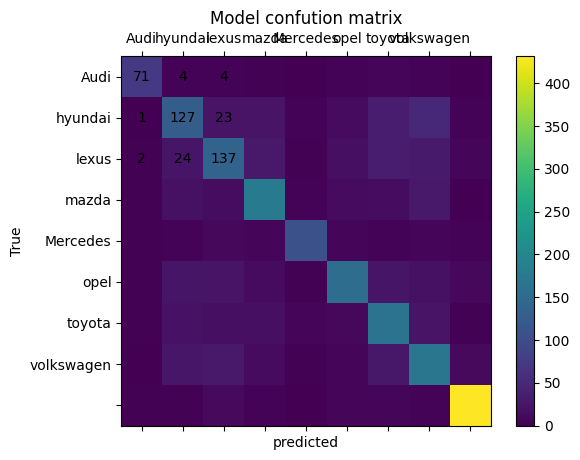

Accuracy: 64.49%


In [10]:
DanhGia_DoChinhXac(model)

2.2 Đánh gia mô hình InceptionV3

75/75 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step 


C:\Users\VTOS\AppData\Local\Temp\ipykernel_6280\3093072512.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+ classifies2)
C:\Users\VTOS\AppData\Local\Temp\ipykernel_6280\3093072512.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+ classifies2)


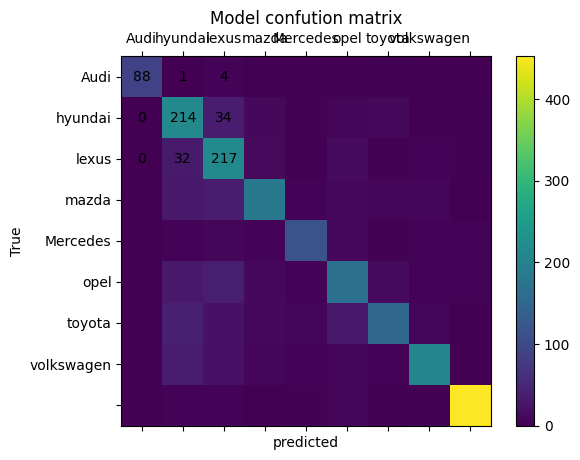

Accuracy: 74.99%


In [16]:
DanhGia_DoChinhXac(model2)

2.3 Đánh gia mô hình MobileNet

75/75 ━━━━━━━━━━━━━━━━━━━━ 28s 341ms/step


C:\Users\VTOS\AppData\Local\Temp\ipykernel_6280\3093072512.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+ classifies2)
C:\Users\VTOS\AppData\Local\Temp\ipykernel_6280\3093072512.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+ classifies2)


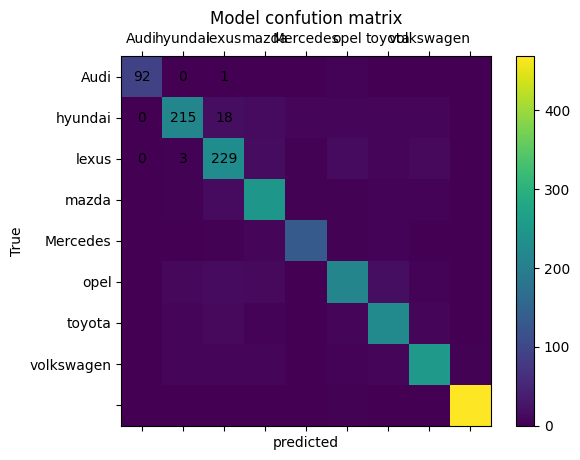

Accuracy: 86.83%


In [26]:
DanhGia_DoChinhXac(model3)

2.4 Đánh gia mô hình Lenet

75/75 ━━━━━━━━━━━━━━━━━━━━ 12s 162ms/step


C:\Users\VTOS\AppData\Local\Temp\ipykernel_10772\3093072512.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+ classifies2)
C:\Users\VTOS\AppData\Local\Temp\ipykernel_10772\3093072512.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+ classifies2)


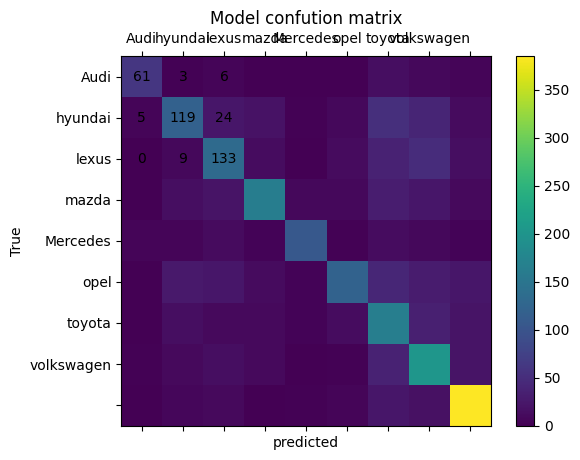

Accuracy: 60.85%


In [12]:
DanhGia_DoChinhXac(model4)

Luu mo hinh h5

In [28]:
#model.save('h5/CNN.h5')
#model2.save('h5/inceptionV3.h5')
model3.save('h5/MobileNet.h5')
#model5.save('h5/vgg16.h5')

ValueError: Unable to synchronously create dataset (name already exists)